# Fast RCNN for object detection
Este notebook apresenta:
- como usar o [SDK](https://platiagro.github.io/sdk/) para carregar datasets, salvar modelos e outros artefatos.
- como declarar parâmetros e usá-los para criar componentes reutilizáveis.


**Este Notebook seguirá os seguintes tutoriais:**
- Faster RCNN Train  <br>
https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train <br>
- Faster RCNN Inference <br>
https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference <br>
- Faster RCNN Metric + scrpit details <br>
https://www.kaggle.com/pestipeti/competition-metric-details-script <br>
- TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL <br>
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html <br>
- TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL <br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial

## Declare parâmetros e hiperparâmetros para o modelo
Os componentes podem declarar (e usar) estes parâmetros como padrão:
- dataset
- target

Use estes parâmetros para carregar/salvar conjutos de dados, modelos, métricas e figuras com a ajuda do [SDK da PlatIAgro](https://platiagro.github.io/sdk/). <br>
É possível também declarar parâmetros personalizados para serem definidos ao executar um experimento. 

Selecione os hiperparâmetros e seus respectivos valores para serem usados ao treinar o modelo:
- language

Estes parâmetros são alguns dos oferecidos pela classe do modelo, você também pode utilizar outros existentes. <br>
Dê uma olhada nos [parâmetros do modelo](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn-impute-simpleimputer) para mais informações.

In [ ]:
# parâmetros
dataset = "" #@param {type:"string"}
target = "sentiment" #@param {type:"string", label:"Atributo alvo", description:"Seu modelo será treinado para prever os valores do alvo."}
#Hyperparâametros
train_batch_size =  2 #@param {type:"integer"}
valid_batch_size =  4 #@param {type:"integer"}
test_batch_size =   2 #@param {type:"integer"}
max_epochs = 2 #@param {type:"integer"}
accumulate_grad_batches = 8  #@param {type:"integer"}
learning_rate = 0.005 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
weight_decay = 0.0005 #@param {type:"number"}
num_classes = 2 #@param {type:"integer"}
detection_threshold = 0.5 #@param {type:"number"}
seed =7 #@param {type:"integer"}

# selected features to perform the model
filter_type = "incluir" #@param ["incluir","remover"]  {type:"string",label:"Modo de seleção das features", description:"Se deseja informar quais features deseja incluir no modelo, selecione a opção [incluir]. Caso deseje informar as features que não devem ser utilizadas, selecione [remover]. "}
model_features = "review" #@param {type:"string",multiple:true,label:"Features para incluir/remover no modelo",description:"Seu modelo será feito considerando apenas as features selecionadas. Caso nada seja especificado, todas as features serão utilizadas"}
coord_format = "coco" #@param ["coco","pascal_voc"]  {type:"string"}


## Estapas Google Coolab

In [1]:
! pip install torchvision --quiet
! pip install pytorch-lightning==0.8.4 --quiet
! pip install transformers --quiet
! pip install ftfy --quiet
! pip install -U git+https://github.com/albumentations-team/albumentations --quiet
! pip install numba --quiet

     |████████████████████████████████| 307kB 2.9MB/s 
     |████████████████████████████████| 829kB 8.9MB/s 
     |████████████████████████████████| 276kB 16.8MB/s 
     |████████████████████████████████| 1.1MB 2.9MB/s 
     |████████████████████████████████| 1.1MB 17.9MB/s 
     |████████████████████████████████| 890kB 20.5MB/s 
     |████████████████████████████████| 3.0MB 24.0MB/s 
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 952kB 2.7MB/s 


In [ ]:
! pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.4.6
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.2.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.3
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
debugpy==1.0.0rc2
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.2
distributed==1.25.3
Django==3.1.1
dlib==19.18.0
dm-tr

In [ ]:
#Mount drive
print("\nMounting Drive...\n")
from google.colab import drive
drive.mount('/content/drive')


Mounting Drive...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/content/drive/My Drive/Computer_Vision/datasets_imagem/wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

## Configurações Gerais



Definindo GPU como padrão e verificando status de hardware

In [ ]:
from multiprocessing import cpu_count
import torch
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
if dev == "cpu":
    print(f"number of CPU cores: {cpu_count()}")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")

GPU: Tesla K80, number of CPU cores: 2


Impedir excesso de logs

In [ ]:
import logging
logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

Fixar semente de pesos aleatporios para replicabilidade

In [ ]:
import random
random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [ ]:
import pandas as pd
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


## Manipulando os dados

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [ ]:
test_df.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


## Criação do Dataset -> Utilizando formato Pascal Voc



*   pascal_voc: min/max coordinates ```[x_min, y_min, x_max, y_max] ```<br>
*   coco: width/height instead of maxes ```[x_min, y_min, width, height]```




In [ ]:
%%writefile Dataset.py
from torch.utils.data import Dataset
import torch
import cv2
import numpy as np
import pandas as pd
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,step = "Experiment"):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.step = step

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0


        if self.step ==  "Experiment":

            # transforming [x_min, y_min, width, height] to x_min, y_min, x_max, y_max]
            # it is an albumentations requirement
            boxes = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            # there is only one class
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            
            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
            
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            # target['masks'] = None
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {'image': image,'bboxes': target['boxes'],'labels': labels}
                sample = self.transforms(**sample)
                image = sample['image']
                
                # Reempilia as bboxes em m tensor só como estava antes
            stacked_boxes = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(stacked_boxes, dtype=torch.float32)


            return image, image_id,target

        if self.step ==  "Deployment":
          if self.transforms:
            sample = {'image': image,}
            sample = self.transforms(**sample)
            image = sample['image']


          return image, image_id
   

    def __len__(self) -> int:
        return self.image_ids.shape[0]

Overwriting Dataset.py


In [ ]:
%run Dataset.py

Transformações com Albumentations

In [ ]:
def get_debug_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
ds_debug = WheatDataset(train_df, DIR_TRAIN, get_debug_transform())
print("------->Testando Dataset<-------")
image, target, image_id = ds_debug[0]
print(image)
print(target)
print(image_id)

------->Testando Dataset<-------
tensor([[[0.2902, 0.2902, 0.2824,  ..., 0.1412, 0.1176, 0.1020],
         [0.2667, 0.2667, 0.2667,  ..., 0.1294, 0.1059, 0.0941],
         [0.2549, 0.2549, 0.2549,  ..., 0.1137, 0.0941, 0.0824],
         ...,
         [0.8667, 0.8784, 0.8667,  ..., 0.2196, 0.2196, 0.2196],
         [0.8196, 0.8078, 0.7882,  ..., 0.2275, 0.2314, 0.2353],
         [0.7529, 0.7294, 0.7176,  ..., 0.2392, 0.2431, 0.2471]],

        [[0.3804, 0.3804, 0.3804,  ..., 0.1333, 0.1098, 0.0941],
         [0.3647, 0.3647, 0.3608,  ..., 0.1216, 0.0980, 0.0863],
         [0.3569, 0.3569, 0.3569,  ..., 0.1059, 0.0863, 0.0745],
         ...,
         [0.8275, 0.8314, 0.8157,  ..., 0.2196, 0.2196, 0.2196],
         [0.7804, 0.7608, 0.7373,  ..., 0.2275, 0.2314, 0.2353],
         [0.7137, 0.6824, 0.6667,  ..., 0.2392, 0.2431, 0.2471]],

        [[0.2667, 0.2706, 0.2667,  ..., 0.1373, 0.1137, 0.0980],
         [0.2510, 0.2510, 0.2588,  ..., 0.1255, 0.1020, 0.0902],
         [0.2588, 0.2588,

## Criação do Dataloader

Collate para colocar batch em tuplas

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

Criando dataloader

In [ ]:
debug_loader = DataLoader(
    ds_debug,
    batch_size=4,
    shuffle=False,
    num_workers=cpu_count(),
    collate_fn=collate_fn
)

Testando dataloader

In [ ]:
print("------->Testando Dataloader <-------")
next(iter(debug_loader))

------->Testando Dataloader <-------


((tensor([[[0.7529, 0.7294, 0.7176,  ..., 0.2392, 0.2431, 0.2471],
           [0.8196, 0.8078, 0.7882,  ..., 0.2275, 0.2314, 0.2353],
           [0.8667, 0.8784, 0.8667,  ..., 0.2196, 0.2196, 0.2196],
           ...,
           [0.2549, 0.2549, 0.2549,  ..., 0.1137, 0.0941, 0.0824],
           [0.2667, 0.2667, 0.2667,  ..., 0.1294, 0.1059, 0.0941],
           [0.2902, 0.2902, 0.2824,  ..., 0.1412, 0.1176, 0.1020]],
  
          [[0.7137, 0.6824, 0.6667,  ..., 0.2392, 0.2431, 0.2471],
           [0.7804, 0.7608, 0.7373,  ..., 0.2275, 0.2314, 0.2353],
           [0.8275, 0.8314, 0.8157,  ..., 0.2196, 0.2196, 0.2196],
           ...,
           [0.3569, 0.3569, 0.3569,  ..., 0.1059, 0.0863, 0.0745],
           [0.3647, 0.3647, 0.3608,  ..., 0.1216, 0.0980, 0.0863],
           [0.3804, 0.3804, 0.3804,  ..., 0.1333, 0.1098, 0.0941]],
  
          [[0.5059, 0.4784, 0.4510,  ..., 0.2392, 0.2431, 0.2471],
           [0.5725, 0.5569, 0.5294,  ..., 0.2275, 0.2314, 0.2353],
           [0.6275, 0.

## Testando um exemplar

Recuperando elementos do dataset/dataloader

In [ ]:
images, image_ids,targets = next(iter(debug_loader)) 
images = list(image.to(device) for image in images) 
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

Recuperando boxes e a imagem

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Plotando Imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


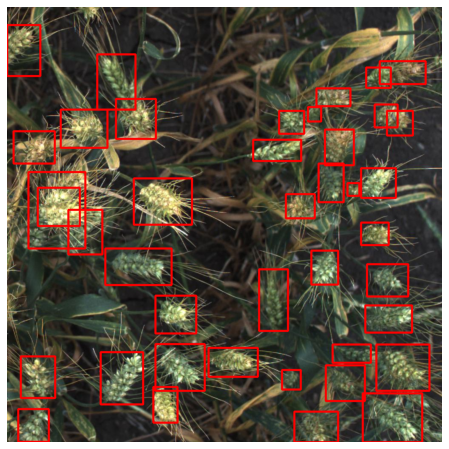

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [ ]:
import numpy as np
# from platiagro import stat_dataset

# metadata = stat_dataset(name=dataset)
# featuretypes = metadata["featuretypes"]

#columns = df.columns.to_numpy()
# featuretypes = np.array(featuretypes)
#target_index = np.argwhere(columns == target)
#columns = np.delete(columns, target_index)
# featuretypes = np.delete(featuretypes, target_index)

## Remoção de linhas com valores faltantes no atributo alvo

Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# df.dropna(subset = [target],inplace=True)
# y = df[target].to_numpy()
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

## Filtragem das features 

Seleciona apenas as features que foram declaradas no parâmetro model_features. Se nenhuma feature for especificada, todo o conjunto de dados será utilizado para a modelagem.

In [ ]:
# if filter_type == 'incluir':
#     if len(model_features) >= 1:
#         columns_index = (np.where(np.isin(columns,model_features)))[0]
#         columns_index.sort()
#         columns_to_filter = columns[columns_index]
#         featuretypes = featuretypes[columns_index]
#     else:
#         columns_to_filter = columns
# else:
#     if len(model_features) >= 1:
#         columns_index = (np.where(np.isin(columns,model_features)))[0]
#         columns_index.sort()
#         columns_to_filter = np.delete(columns,columns_index)
#         featuretypes = np.delete(featuretypes,columns_index)
#     else:
#         columns_to_filter = columns

# # keep the features selected
# df_model = df[columns_to_filter]
# X = df_model.to_numpy()

## Divisão do datset em subconjuntos de treino e teste

Subconjunto de Treino: amostras de dados usado para treinar o modelo (``fit``). <br>
Subconjunto de Teste: a amostra de dados usada para fornecer uma avaliação imparcial de um modelo adequado ao conjunto de dados de treinamento.

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit

# X_train, X_, y_train, y_  = train_test_split(X, y,  train_size=0.8,random_state=seed,stratify = y)
# X_valid, X_test, y_valid, y_test = train_test_split(X_, y_,  train_size=0.5,stratify = y_)

## Classe para tirar a média entre as losses

Diversas funções de custo são levadas em consideração. Será tirada uma média entre elas para se ter uma única função de otimização. Estas são:

*   loss_box_reg
*   loss_classifier
*   loss_objectness
*   loss_rpn_box_reg



In [ ]:
%%writefile Averager.py
class Averager:    
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

Overwriting Averager.py


In [ ]:
%run Averager.py

<Figure size 432x288 with 0 Axes>

## Recuperando os pesos

In [ ]:
import os
cwd = os.getcwd()
cwd

'/content'

In [ ]:
# ! gsutil cp gs://platiagro/Glove_Bag_Of_Embeddings_For_Sentence_Classification/epoch=199.ckpt  /home/jovyan/tasks/GloVe_Bag_Of_Sentence_Classification

## Funções que calculam a métrica de precisão baseada em Intersect Over Union (IOU)
Foi escolhido fazer por fora do modelo e enviar as funções para que seja possível utilizar a biblioteca Numba, paralelizando o processamento em CPU

In [ ]:
from numba import jit

@jit(nopython=True)
def calculate_iou(gt, pr, form='coco') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.
    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

## Modelo Pytorch Lightning

In [ ]:
%%writefile Model_Lightning.py
#general
from torch.utils.data import DataLoader
from multiprocessing import cpu_count
import pytorch_lightning as pl
import torch
import functools
import traceback
import psutil
import pandas as pd
import numpy as np
import cv2
#albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
#numba -> CPU paralelisation
from numba import jit

class FastRCNNFinetuner(pl.LightningModule):

    def __init__(self, 
                 hyperparams,
                 model_parameters,
                 dataset_infos,
                 extra_infos):

        super(FastRCNNFinetuner, self).__init__()

        #---------- hyperparams
        self.learning_rate = hyperparams['learning_rate']
        self.momentum = hyperparams['momentum']
        self.weight_decay = hyperparams['weight_decay']
        self.detection_threshold = hyperparams['detection_threshold']
        self.train_batch_size = hyperparams['train_batch_size']
        self.valid_batch_size = hyperparams['valid_batch_size']
        self.test_batch_size = hyperparams['test_batch_size']
        
        #---------- model_parameters
        self.num_classes = model_parameters['num_classes'] # 1 class (wheat) + background
        self.coord_format = model_parameters['coord_format'] # coco ou pascal_voc
        self.Averager = model_parameters['Averager']
        self.loss_hist  = self.Averager()
        self.calculate_image_precision = model_parameters['calculate_image_precision']
        self.calculate_precision = model_parameters['calculate_precision']
        self.find_best_match = model_parameters['find_best_match']
        self.calculate_iou = model_parameters['calculate_iou']
        

        #---------- dataset_infos
        self.all_data = dataset_infos['all_data']
        self.DIR_TRAIN = dataset_infos['DIR_TRAIN']
        self.DIR_TEST = dataset_infos['DIR_TEST']
        self.CustomDataset = dataset_infos['CustomDataset']
        
        #---------- extra_infos
        self.overfit = extra_infos['overfit']
        
         #---------- other_infos
        self.predict_proba  =  torch.nn.Softmax(dim=1)
        self.step = 'Experiment'

        #---------- Dados para gráfico de Acurácia e Loss
        self.df_performance_train_batch = pd.DataFrame(columns=['train_batch_loss'])
        self.df_performance_train_epoch = pd.DataFrame(columns=['train_epoch_loss'])
        self.df_performance_valid_batch = pd.DataFrame(columns=['valid_batch_loss','valid_batch_iou'])
        self.df_performance_valid_epoch = pd.DataFrame(columns=['valid_epoch_loss','valid_epoch_iou'])
        self.df_performance_test_batch = pd.DataFrame(columns=['test_batch_iou'])
        self.df_performance_test_epoch = pd.DataFrame(columns=['test_epoch_iou'])


        #---------- Carregamento datasets
        if self.overfit:
            self.train_dataset = self.CustomDataset(self.all_data[0], self.DIR_TRAIN, self.get_train_transform())
            self.valid_dataset = self.CustomDataset(self.all_data[0], self.DIR_TRAIN, self.get_train_transform())
            self.test_dataset =  self.CustomDataset(self.all_data[0], self.DIR_TRAIN, self.get_train_transform())
        else:
            self.train_dataset = self.CustomDataset(self.all_data[0], self.DIR_TRAIN, self.get_train_transform())
            self.valid_dataset = self.CustomDataset(self.all_data[1], self.DIR_TRAIN, self.get_valid_transform())
            self.test_dataset =  self.CustomDataset(self.all_data[2], self.DIR_TRAIN, self.get_valid_transform())


        #---------- Resultados
        self.df_valid = pd.DataFrame(columns=['IMAGE_ID','PREDICTION_STRING','PRECISION_IOU'])
        self.df_test = pd.DataFrame(columns=['IMAGE_ID','PREDICTION_STRING','PRECISION_IOU'])
        self.result_valid = []
        self.result_test = []

        #---------- Preditor Fast-RCNN
        # load a model; pre-trained on COCO
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # get number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)

    def predict(self,df, image_dir):
        self.step = "Deployment"
        inference_dataset = self.CustomDataset(df, image_dir,self.get_test_transform(),step = self.step)
        dataloader = DataLoader(inference_dataset, batch_size=self.test_batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)    
        for batch in dataloader:
            self.test_step(batch, None)
        return self.df_test
            
    def forward(self, images, image_ids,targets = None,info_requested='loss'):
        
        if info_requested == 'loss':
          self.model.train()
          images = list(image for image in images)
          targets = [{k: v for k, v in t.items()} for t in targets]
          loss_dict = self.model(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          self.loss_hist.send(loss_value)
          retorno = losses

        if info_requested == 'predictions':
          self.model.eval()
          results = []
          images = list(image for image in images)
          outputs = self.model(images)

          for i, image in enumerate(images):

              boxes = outputs[i]['boxes'].data.cpu().numpy()
              scores = outputs[i]['scores'].data.cpu().numpy()

              # Sort highest confidence -> lowest confidence
              boxes_sorted_idx = np.argsort(scores)[::-1]
              boxes = boxes[boxes_sorted_idx]
                            
              #eliminate boxes with scores under detection_threshold
              # if you enter model in pascal_voc it will output in pascal_voc
              boxes = boxes[scores >= self.detection_threshold].astype(np.int32)
              boxes_prediction_string = boxes.copy()
              scores = scores[scores >= self.detection_threshold]
              image_id = image_ids[i]
              
              #Converting from Pascal Voc to  COCO-> Only for prediction String
              boxes_prediction_string[:, 2] = boxes_prediction_string[:, 2] - boxes_prediction_string[:, 0]
              boxes_prediction_string[:, 3] = boxes_prediction_string[:, 3] - boxes_prediction_string[:, 1]
              
              result = {
                  'image_id': image_id,
                  'boxes':boxes,
                  'scores':scores,
                  'PredictionString': self.format_prediction_string(boxes_prediction_string, scores)
              }

              results.append(result)
          retorno = results
        return retorno
        
    def training_step(self, batch, batch_nb):
        # batch
        images, image_ids,targets  = batch
         
        # loss
        loss = self.forward(images, image_ids,targets,'loss')
        
        # What to log
        tensorboard_logs = {'loss': loss}

        self.df_performance_train_batch = self.df_performance_train_batch.append(pd.Series([loss.item()], index=self.df_performance_train_batch.columns ), ignore_index=True)

        return {'loss': loss, 'train_loss_batch': loss,'log': tensorboard_logs}
     
    def training_epoch_end(self, outputs):
        if not outputs: return {}
        
        temp_avg_loss_batch = [x['train_loss_batch'] for x in outputs]
  
        avg_train_loss = torch.stack(temp_avg_loss_batch).mean()

        self.df_performance_train_epoch = self.df_performance_train_epoch.append(pd.Series([avg_train_loss.item()], index=self.df_performance_train_epoch.columns ), ignore_index=True)

        tensorboard_logs = {'avg_train_loss': avg_train_loss}

        return {'log': tensorboard_logs}
 
    def validation_step(self, batch, batch_nb):
        # batch
        images, image_ids,targets  = batch
         
        # loss
        loss = self.forward(images, image_ids,targets,'loss')

        # Inference
        outputs = self.forward(images, image_ids,targets,'predictions')

        #constructing dataframe
        ious = np.zeros(len(targets))
        for iter in zip(enumerate(outputs),targets):
            i = iter[0][0]
            output = iter[0][1]
            target = iter[1]
            gts_boxes = target['boxes'].data.cpu().numpy().astype(np.int32)
            pred_boxes = output['boxes']
            image = images[i].permute(1,2,0).cpu().numpy()
            image_id = output['image_id']
            prediction_string = output['PredictionString']
            image_precision =  self.calculate_image_precision(gts_boxes, pred_boxes,(self.detection_threshold,),'pascal_voc')
            ious[i] = image_precision 
            self.df_valid = self.df_valid.append(pd.Series([image_id,prediction_string,image_precision], index=self.df_valid.columns), ignore_index=True)
            self.result_valid.append({'image_id':image_id,'image':image,'gts_boxes':gts_boxes, 'pred_boxes':pred_boxes})
        #mean batch dataframe
        mean_batch_ious = np.mean(ious)
        self.df_performance_valid_batch = self.df_performance_valid_batch.append(pd.Series([loss.item(),mean_batch_ious], index=self.df_performance_valid_batch.columns ), ignore_index=True)

        return {'valid_iou_batch': mean_batch_ious, 'valid_loss_batch': loss}

    def validation_epoch_end(self, outputs):
        if not outputs: return {}

        temp_avg_loss_batch = [x['valid_loss_batch'] for x in outputs]
        temp_avg_iou_batch = [x['valid_iou_batch'] for x in outputs]

        avg_valid_loss = torch.stack(temp_avg_loss_batch).mean()
        avg_valid_iou = np.mean(temp_avg_iou_batch)

        self.df_performance_valid_epoch = self.df_performance_valid_epoch.append(pd.Series([avg_valid_loss.item(),avg_valid_iou], index=self.df_performance_valid_epoch.columns ), ignore_index=True)

        tensorboard_logs = {'avg_valid_iou': avg_valid_iou,'avg_valid_loss': avg_valid_loss}

        return {'avg_valid_iou': avg_valid_iou, 'log': tensorboard_logs}


    def test_step(self, batch, batch_nb):
        # batch
        if self.step == "Experiment":
            # batch
            images, image_ids,targets  = batch
            
            # Inference
            outputs = self.forward(images, image_ids,targets,'predictions')

            #constructing dataframe
            ious = np.zeros(len(targets))
            for iter in zip(enumerate(outputs),targets):
                i = iter[0][0]
                output = iter[0][1]
                target = iter[1]
                gts_boxes = target['boxes'].data.cpu().numpy().astype(np.int32)
                pred_boxes = output['boxes'].astype(np.int32)
                image = images[i].permute(1,2,0).cpu().numpy()
                image_id = output['image_id']
                prediction_string = output['PredictionString']
                image_precision =  self.calculate_image_precision(gts_boxes, pred_boxes,(self.detection_threshold,),'pascal_voc')
                ious[i] = image_precision 
                self.df_test = self.df_test.append(pd.Series([image_id,prediction_string,image_precision], index=self.df_test.columns), ignore_index=True)
                self.result_test.append({'image_id':image_id,'image':image,'gts_boxes':gts_boxes, 'pred_boxes':pred_boxes})

            #mean batch dataframe
            mean_batch_ious = np.mean(ious)
            self.df_performance_test_batch = self.df_performance_test_batch.append(pd.Series([mean_batch_ious], index=self.df_performance_test_batch.columns), ignore_index=True)

            retorno = {'test_iou_batch': mean_batch_ious}
                
        if self.step == "Deployment":
            # batch
            images, image_ids  = batch

            # Inference
            outputs = self.forward(images, image_ids,'predictions')
            not_apply_list = ['N/A'] * len(outputs)

            #constructing dataframe
            for iter in zip(enumerate(outputs),not_apply_list):
                i = iter[0][0]
                output = iter[0][1]
                na = iter[1]
                pred_boxes = output['boxes'].astype(np.int32)
                image = images[i].permute(1,2,0).cpu().numpy()
                image_id = output['image_id']
                prediction_string = output['PredictionString']
                self.df_test = self.df_test.append(pd.Series([image_id,prediction_string,na], index=self.df_test.columns), ignore_index=True)
                self.result_test.append({'image_id':image_id,'image':image,'pred_boxes':pred_boxes})

            retorno = None
            
        return retorno

    def test_epoch_end(self, outputs):
        if not outputs: return {}

        if self.step == "Experiment":
          avg_test_iou = np.mean([x['test_iou_batch'] for x in outputs])
          tensorboard_logs = {'avg_test_iou': avg_test_iou}
          retorno = {'avg_test_iou': avg_test_iou, 'log': tensorboard_logs}

        if self.step == "Deployment":
          retorno = None

        return retorno

    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        return torch.optim.SGD( params,
                               lr=self.learning_rate,
                               momentum=self.momentum,
                               weight_decay=self.weight_decay)
    
    def my_collate(self,batch):
        return tuple(zip(*batch))

    def gpu_mem_restore(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                type, val, tb = sys.exc_info()
                traceback.clear_frames(tb)
                raise type(val).with_traceback(tb) from None
        return wrapper
    
        # Albumentations
    def get_train_transform(self):
        return A.Compose([
            A.Flip(0.5),
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    def get_valid_transform(self):
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    def get_test_transform(self):
        return A.Compose([
            # A.Resize(512, 512),
            ToTensorV2(p=1.0)
        ])
    
    def format_prediction_string(self, boxes, scores):
      pred_strings = []
      for j in zip(scores, boxes):
          pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

      return " ".join(pred_strings)

    @gpu_mem_restore
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_batch_size, shuffle=False,num_workers=cpu_count(), collate_fn=self.my_collate)

    @gpu_mem_restore
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.valid_batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)    

    @gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.test_batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)

Overwriting Model_Lightning.py


In [ ]:
%run Model_Lightning.py

In [ ]:
del model

NameError: ignored

Parâmetros do Modelo

In [ ]:
all_data = [train_df,valid_df,test_df]
hyperparams = {'learning_rate':learning_rate,'momentum':momentum,'weight_decay':weight_decay,'detection_threshold':detection_threshold,'train_batch_size':train_batch_size,'valid_batch_size':valid_batch_size,'test_batch_size':test_batch_size}
model_parameters = {'num_classes': num_classes,'coord_format':coord_format,'Averager':Averager,'calculate_iou':calculate_iou,'find_best_match':find_best_match,'calculate_precision':calculate_precision,'calculate_image_precision':calculate_image_precision}
dataset_infos = {'all_data':all_data,'CustomDataset':WheatDataset,'DIR_TRAIN':DIR_TRAIN,'DIR_TEST':DIR_TEST}
extra_infos = {'overfit':False}

In [ ]:
model = FastRCNNFinetuner(hyperparams=hyperparams,
                       model_parameters=model_parameters,
                       dataset_infos=dataset_infos,
                       extra_infos = extra_infos)  
sum([torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]) # trainable parameters

KeyboardInterrupt: ignored

In [ ]:
trainer = pl.Trainer(gpus=0, 
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     fast_dev_run=True)
trainer.fit(model)

In [ ]:
trainer.test(model)

Recuperando ou treinando o modelo

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
import os
cwd = '/content/drive/My Drive/Computer_Vision/Object_Detection/FastRCNN/checkpoints'
checkpoint_path = cwd + '/epoch=1.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir, save_top_k=-1)  # Keeps all checkpoints.

resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    weights_retrieved = True
    print(f"Restoring checkpoint: {checkpoint_path}")
    resume_from_checkpoint = checkpoint_path
else:
    weights_retrieved = False


trainer = pl.Trainer(gpus=1,
                     max_epochs=2,
                     check_val_every_n_epoch=1,
                     profiler=True,
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=1,
                     resume_from_checkpoint=resume_from_checkpoint)

model = FastRCNNFinetuner(hyperparams=hyperparams,
                       model_parameters=model_parameters,
                       dataset_infos=dataset_infos,
                       extra_infos = extra_infos) 

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Files in /content/drive/My Drive/Computer_Vision/Object_Detection/FastRCNN/checkpoints: ['epoch=0.ckpt', 'epoch=1.ckpt']
Saving checkpoints to /content/drive/My Drive/Computer_Vision/Object_Detection/FastRCNN/checkpoints
Restoring checkpoint: /content/drive/My Drive/Computer_Vision/Object_Detection/FastRCNN/checkpoints/epoch=1.ckpt



  | Name          | Type       | Params
---------------------------------------------
0 | predict_proba | Softmax    | 0     
1 | model         | FasterRCNN | 41 M  
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.037798       	|  0.037798       
on_train_end        	|  0.0015037      	|  0.0015037      



1

In [ ]:
trainer.test(model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_iou': 0.7241922921288567}
--------------------------------------------------------------------------------



Visualizando resultados

In [ ]:
model.df_valid

,IMAGE_ID,PREDICTION_STRING,PRECISION_IOU
0,bbce58f71,0.9981 926 911 98 110 0.9972 312 581 135 110 0...,0.869565
1,b45096c1e,0.9986 734 347 192 94 0.9980 612 269 150 70 0....,0.875000
2,b3c96d5ad,0.9965 816 808 116 67 0.9953 912 706 97 83 0.9...,0.833333
3,1be796d9d,0.9959 869 282 120 72 0.9957 819 403 112 69 0....,0.937500
4,ba9133208,0.9941 932 207 91 77 0.9941 864 417 102 97 0.9...,0.666667
5,ac891ac35,0.9980 124 213 146 78 0.9979 212 138 142 101 0...,0.772727
6,a5904a10b,0.9961 257 568 112 99 0.9951 147 87 116 72 0.9...,0.809524
7,ea0e9e846,0.9978 836 753 138 67 0.9975 1 360 148 90 0.99...,0.840000


In [ ]:
model.df_test

,IMAGE_ID,PREDICTION_STRING,PRECISION_IOU
0,bbce58f71,0.9981 926 911 98 110 0.9972 312 581 135 110 0...,0.869565
1,b45096c1e,0.9986 734 347 192 94 0.9980 612 269 150 70 0....,0.875000
2,b3c96d5ad,0.9965 816 808 116 67 0.9953 912 706 97 83 0.9...,0.833333
3,1be796d9d,0.9959 869 282 120 72 0.9957 819 403 112 69 0....,0.937500
4,ba9133208,0.9941 932 207 91 77 0.9941 864 417 102 97 0.9...,0.666667
...,...,...,...
660,990c1777d,0.9979 857 40 155 153 0.9970 487 320 183 105 0...,0.750000
661,bce2fdc4d,0.9946 743 853 122 82 0.9934 125 828 130 78 0....,0.533333
662,a5c8d5f5c,0.9965 726 556 101 84 0.9956 622 208 111 92 0....,0.709677
663,e6b5e296d,0.9960 531 615 106 83 0.9918 474 955 123 67 0....,0.600000


## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [ ]:
from platiagro import save_metrics

save_metrics(confusion_matrix=confusion_matrix,commom_metrics=commom_metrics)

<Figure size 432x288 with 0 Axes>

## Salva figuras

Utiliza a função `save_figures` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar figuras do [matplotlib](https://matplotlib.org/3.2.1/gallery/index.html). <br>

A avaliação do desempenho do modelo pode ser feita por meio da análise da [Curva ROC (ROC)](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor).  Esse gráfico permite avaliar a performance de um classificador binário para diferentes pontos de cortes. A métrica [AUC (Area under curve)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) também é calculada e indicada na legenda do gráfico.<br>
Se a variável resposta tiver mais de duas categorias, o cálculo da curva ROC e AUC é feito utilizando o algoritmo [one-vs-rest](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics), ou seja, calcula-se a curva ROC e AUC de cada classe em relação ao restante.

In [ ]:
from matplotlib.pyplot import cm
#from platiagro import save_figure
#from platiagro import list_figures
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np


def overlaping_multiple_plots(rows,columns,results):
    fig=plt.figure(figsize=(15, 15))
    ax = []
    for i in range(1, columns*rows +1):
        result = results[i]
        sample = result['image']
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

        for pred_box in result['pred_boxes']:
            cv2.rectangle(
                sample,
                (pred_box[0], pred_box[1]),
                (pred_box[2],pred_box[3]),
                (220, 0, 0), 2
            )

        for gt_box in  result['gts_boxes']:    
            cv2.rectangle(
                sample,
                (gt_box[0], gt_box[1]),
                (gt_box[2], gt_box[3]),
                (0, 0, 220), 2
            )

        ax.append( fig.add_subplot(rows, columns, i) )
        ax[-1].set_title(result['image_id'])
        fig.suptitle("RED: Predicted | BLUE - Ground-truth")
        plt.imshow(sample)
    plt.show()
    plt.close()

def inference_multiple_plots(rows,columns,results):
    fig=plt.figure(figsize=(15, 15))
    ax = []
    for i in range(1, columns*rows +1):
        result = results[i]
        sample = result['image']
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        
        for pred_box in result['pred_boxes']:
            cv2.rectangle(
                sample,
                (pred_box[0], pred_box[1]),
                (pred_box[2],pred_box[3]),
                (220, 0, 0), 2
            )

        ax.append( fig.add_subplot(rows, columns, i) )
        ax[-1].set_title(result['image_id']) 
        fig.suptitle("RED: Predicted")
        plt.imshow(sample)
    plt.show()
    plt.close()

def performance_loss_visualization(loss_list,epoch_or_batch="Epoch",step = "Train"):
    x = range(len(loss_list))
    # Loss plot
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Loss")
    plt.plot(x, loss_list, '-')
    plt.title(step + ' Loss Performance')
    plt.suptitle(epoch_or_batch + ' - ' + step)
    plt.show()

def performance_loss_iou_visualization(loss_list, iou_list,epoch_or_batch="Epoch",step = "Valid"):
    x = range(len(loss_list))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Loss")
    plt.plot(x, loss_list, '-')
    plt.title(step + ' Loss Performance')
    # Precision plot
    plt.subplot(1, 2, 2)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("IOU")
    plt.plot(x, iou_list, '-')
    plt.title(step + '  IOU Performance') 
    #show
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(epoch_or_batch + ' - ' + step)
    plt.show()

def performance_iou_visualization(iou_list,epoch_or_batch="Epoch",step = "Train"):
    x = range(len(iou_list))
    # Loss plot
    plt.xlabel(epoch_or_batch)
    plt.ylabel("IOU")
    plt.plot(x, iou_list, '-')
    plt.title(step + ' IOU Performance')
    plt.suptitle(epoch_or_batch + ' - ' + step)
    plt.show()


overlaping_multiple_plots(2,2,model.result_valid)
inference_multiple_plots(2,2,model.result_test)
if not weights_retrieved:
    performance_loss_visualization(model.df_performance_train_batch['train_batch_loss'].to_numpy(), epoch_or_batch="Batch",step = "Train")
    performance_loss_visualization(model.df_performance_train_epoch['train_epoch_loss'].to_numpy(), epoch_or_batch="Epoch",step = "Train")
    performance_loss_iou_visualization(model.df_performance_valid_batch['valid_batch_loss'].to_numpy(), model.df_performance_valid_batch['valid_batch_iou'].to_numpy(),epoch_or_batch="Batch",step = "Valid")
    performance_loss_iou_visualization(model.df_performance_valid_epoch['valid_epoch_loss'].to_numpy(), model.df_performance_valid_epoch['valid_epoch_iou'].to_numpy(),epoch_or_batch="Epoch",step = "Valid")
    performance_iou_visualization(model.df_performance_test_batch['test_batch_iou'].to_numpy(), epoch_or_batch="Batch",step = "Test")
    performance_iou_visualization(model.df_performance_test_epoch['test_epoch_iou'].to_numpy(), epoch_or_batch="Epoch",step = "Test")

Output hidden; open in https://colab.research.google.com to view.

## Salva modelo e outros artefatos

Utiliza a função `save_model` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar modelos e outros artefatos.<br>
Essa função torna estes artefatos disponíveis para o notebook de implantação.

Modelo Pytorch Lightining

In [ ]:
file_name = 'pytorch_model.pt'
torch.save(model.state_dict(), f'/tmp/data/{file_name}')

FileNotFoundError: ignored

Artefatos

In [ ]:
import pickle
dataset_infos = {'all_data':all_data}
deployment_infos = {'columns':columns,'X_test':X_test}
artifacts = {'hyperparams':hyperparams,'model_parameters':model_parameters,'dataset_infos':dataset_infos,'extra_infos':extra_infos,'deployment_infos':deployment_infos}
file_name = 'artifacts.p'
pickle.dump(artifacts, open(f'/tmp/data/{file_name}', "wb" ))


NameError: ignored